In [3]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [4]:
# Path rephraser 
def path_rephraser(path: str) -> str:
    return path.replace('\\', '/')

#print(rephrased_path)  # Output: C:/Users/jj402/Desktop/ML
# Rephrase the file path

path = r"C:\Users\jj402\Desktop\ML\loan_default_ml\data\application_train.csv"
rephrased_path = path_rephraser(path)

# Load the dataset
data = pd.read_csv(rephrased_path)

In [5]:
# Missing values table and the mean 
# Identify the null values in each column, find the mean of the missing null values and convert to percentage and then solve it with worst offenders first.

missing_pct = (data.isnull().mean() * 100).sort_values(ascending=False)
# remove columns with 0% missing values

missing_pct = missing_pct[missing_pct > 0.0]

# Filtering the columns related to housing details like 'COMMONAREA_AVG' for combining the housing missingness indicator

housing_columns = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG']
housing_cols = []

for i in housing_columns: # Removing the subscript 'AVG' in all the columns
    if i.endswith('_AVG'):
        z = i.replace('_AVG','_') 
        housing_cols.append(z)

housing_columns = [ # storing all the housing details related columns with different subscripts like 'AVG', 'MODE', etc
    col for col in data.columns
    if col.startswith(tuple(housing_cols))
]

# Addition of the missingness indicator for all the features related to housing details

data['housing_info_missing'] = (
    data[housing_columns].isnull().all(axis=1)
).astype(int)

#data['housing_info_missing'].value_counts(normalize=True)

# Missingness indicators for external sources
data['EXT_SOURCE_1_missing'] = data['EXT_SOURCE_1'].isnull().astype(int)
data['EXT_SOURCE_3_missing'] = data['EXT_SOURCE_3'].isnull().astype(int)
data['EXT_SOURCE_3_missing'] = data['EXT_SOURCE_3'].isnull().astype(int)

# Credit enquiry details missingness indicators
credit_enquiry_cols = [
    col for col in data.columns
    if col.startswith('AMT_REQ_CREDIT_BUREAU')
]

data['Credit_info_missing'] = (
    data[credit_enquiry_cols].isnull().all(axis=1).astype(int)
)

data['OCCUPATION_TYPE'] = data['OCCUPATION_TYPE'].fillna('Not_Applicable') 
# Not adding a missing flag for this case instead encoding a new category for not applicable for unemployed or pensioners


# New features based on credit ratios 
data['credit_income_ratio'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['annuity_income_ratio'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['employment_age_ratio'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

data.replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\jj402\AppData\Local\Temp\ipykernel_18708\2397488074.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['housing_info_missing'] = (
C:\Users\jj402\AppData\Local\Temp\ipykernel_18708\2397488074.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['EXT_SOURCE_1_missing'] = data['EXT_SOURCE_1'].isnull().astype(int)
C:\Users\jj402\AppData\Local\Temp\ipykernel_18708\2397488074.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,housing_info_missing,EXT_SOURCE_1_missing,EXT_SOURCE_3_missing,Credit_info_missing,credit_income_ratio,annuity_income_ratio,employment_age_ratio
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,1.0,0,0,0,0,2.007889,0.121978,0.067329
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0,0,1,0,4.790750,0.132217,0.070862
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,1,1,0,0,2.000000,0.100000,0.011814
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,1,1,1,1,2.316167,0.219900,0.159905
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,1,1,1,0,4.222222,0.179963,0.152418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,0,0,1,1,1.617143,0.174971,0.025303
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,0,1,1,1,3.743750,0.166687,-17.580890
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,1.0,0.0,1.0,0,0,0,0,4.429176,0.195941,0.529266
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0.0,0.0,0.0,0,1,0,0,2.164368,0.118158,0.400134


In [6]:
#Splitting the dataset into training and testing sets

y = data['TARGET']
X = data.drop(columns=['TARGET'])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state= 42, stratify= y)

if y_train.value_counts(normalize=True).all() == y_test.value_counts(normalize=True).all():
    print("\nBoth the splits are same\n") 
else : 
    print("\nBoth the sets are not same\n")


Both the splits are same



In [7]:
# Splitting the numerical columns and categorical columns separately for imputation 

num_cols = X_train.select_dtypes(include = ['int64','float64']).columns
cat_cols = X_train.select_dtypes(include = ['str']).columns

# Preprocessing Imputer pipelines are defined for numeric and categorical values separately

numeric_pipeline = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

numeric_pipeline_wo_scal = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_pipeline = Pipeline( steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])

# Definition of the Preprocessor block using the imputer pipelines 

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_pipeline, num_cols),
        ('cat',categorical_pipeline, cat_cols)
    ]
)

preprocessor_tree = ColumnTransformer(
    transformers = [
        ('num', numeric_pipeline_wo_scal, num_cols),
        ('cat', categorical_pipeline, cat_cols)
    ]
)

In [13]:
# initializing the baseline logistic regression model

base_model = Pipeline(steps = [
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Training the model with the train data
base_model.fit(X_train, y_train)

# Evaluation of the model 

y_pred = base_model.predict(X_test)
y_proba = base_model.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test, y_proba)
recall = recall_score(y_test, y_pred)

print(f"ROC-AUC: {roc_auc:.3f}")
print(f"Recall: {recall:.3f}")

base_precision = precision_score(y_test,y_pred)
base_f1 = f1_score(y_test, y_pred)

base_eval = {"model_name":"LogisticRegression", "roc_auc":roc_auc, "recall": recall, "precision":base_precision, "f1_score": base_f1}

ROC-AUC: 0.750
Recall: 0.010


In [14]:
# Training a controlled tree 
from sklearn.tree import DecisionTreeClassifier

dt_model = Pipeline(steps = [
    ('preprocessing', preprocessor_tree),
    ('classifier', DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=100,
        random_state = 42
    ))
])

dt_model.fit(X_train, y_train)

# Evaluation of the decision tree model
y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:,1]

dt_roc_auc = roc_auc_score(y_test, y_proba_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test,y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)

dt_eval = {"model_name":"DecisionTreeClassifier", "roc_auc":dt_roc_auc, "recall": dt_recall, "precision":dt_precision, "f1_score": dt_f1}
dt_roc_auc, dt_recall

c:\Users\jj402\anaconda3\envs\ml_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


(0.7095209161074709, 0.0)

In [15]:
# Training a random forest classifier model

from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline(steps=[
    ('preprocessor',preprocessor_tree),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        min_samples_leaf=50,
        n_jobs=1,
        random_state=42
    ))
])

rf_model.fit(X_train, y_train)

# Evaluation of the rf model

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:,1]

rf_roc_auc = roc_auc_score(y_test, y_proba_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test,y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

rf_eval = {"model_name":"RandomForestClassifier", "roc_auc": rf_roc_auc, "recall": rf_recall, "precision": rf_precision, "f1_score": rf_f1}

rf_roc_auc, rf_recall

c:\Users\jj402\anaconda3\envs\ml_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


(0.7341954116040341, 0.0)

In [16]:
evaluation_df = pd.DataFrame(columns=[
        "model_name",
        "roc_auc",
        "recall", 
        "precision",
        "f1_score"
    ])

evaluation_df.loc[len(evaluation_df)] = base_eval
evaluation_df.loc[len(evaluation_df)] = dt_eval
evaluation_df.loc[len(evaluation_df)] = rf_eval

evaluation_df

,model_name,roc_auc,recall,precision,f1_score
0,LogisticRegression,0.749874,0.010473,0.577778,0.020574
1,DecisionTreeClassifier,0.709521,0.000000,0.000000,0.000000
2,RandomForestClassifier,0.734195,0.000000,0.000000,0.000000


In [17]:
# Training a controlled tree after adding class weight
from sklearn.tree import DecisionTreeClassifier

dt_model_2 = Pipeline(steps = [
    ('preprocessing', preprocessor_tree),
    ('classifier', DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=100,
        random_state = 42,
        class_weight='balanced'
    ))
])

dt_model_2.fit(X_train, y_train)

# Evaluation of the decision tree model
y_pred_dt_2 = dt_model_2.predict(X_test)
y_proba_dt_2 = dt_model_2.predict_proba(X_test)[:,1]

dt_roc_auc_2 = roc_auc_score(y_test, y_proba_dt_2)
dt_recall_2 = recall_score(y_test, y_pred_dt_2)
dt_precision_2 = precision_score(y_test,y_pred_dt_2)
dt_f1_2 = f1_score(y_test, y_pred_dt_2)

dt_eval_2 = {"model_name":"DecisionTreeClassifier_2", "roc_auc":dt_roc_auc_2, "recall": dt_recall_2, "precision":dt_precision_2, "f1_score":dt_f1_2}
dt_roc_auc_2, dt_recall_2

(0.7122096619810319, 0.7087613293051359)

In [18]:
# Training a random forest classifier model after adding class weight

from sklearn.ensemble import RandomForestClassifier

rf_model_2 = Pipeline(steps=[
    ('preprocessor',preprocessor_tree),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        min_samples_leaf=50,
        n_jobs=1,
        random_state=42,        
        class_weight='balanced'
    ))
])

rf_model_2.fit(X_train, y_train)

# Evaluation of the rf model

y_pred_rf_2 = rf_model_2.predict(X_test)
y_proba_rf_2 = rf_model_2.predict_proba(X_test)[:,1]

rf_roc_auc_2 = roc_auc_score(y_test, y_proba_rf_2)
rf_recall_2 = recall_score(y_test, y_pred_rf_2)
rf_precision_2 = precision_score(y_test,y_pred_rf_2)
rf_f1_2 = f1_score(y_test, y_pred_rf_2)

rf_eval_2 = {"model_name":"RandomForestClassifier_2", "roc_auc": rf_roc_auc_2, "recall": rf_recall_2, "precision": rf_precision_2, "f1_score": rf_f1_2}

rf_roc_auc_2, rf_recall_2

(0.7310687672314572, 0.6414904330312186)

In [19]:
evaluation_df.loc[len(evaluation_df)] = dt_eval_2
evaluation_df.loc[len(evaluation_df)] = rf_eval_2

In [20]:
evaluation_df

,model_name,roc_auc,recall,precision,f1_score
0,LogisticRegression,0.749874,0.010473,0.577778,0.020574
1,DecisionTreeClassifier,0.709521,0.000000,0.000000,0.000000
2,RandomForestClassifier,0.734195,0.000000,0.000000,0.000000
3,DecisionTreeClassifier_2,0.712210,0.708761,0.137343,0.230098
4,RandomForestClassifier_2,0.731069,0.641490,0.157510,0.252918


In [21]:
base_precision = precision_score(y_test,y_pred)
base_f1 = f1_score(y_test, y_pred)

base_precision, base_f1

(0.5777777777777777, 0.020573689416419388)

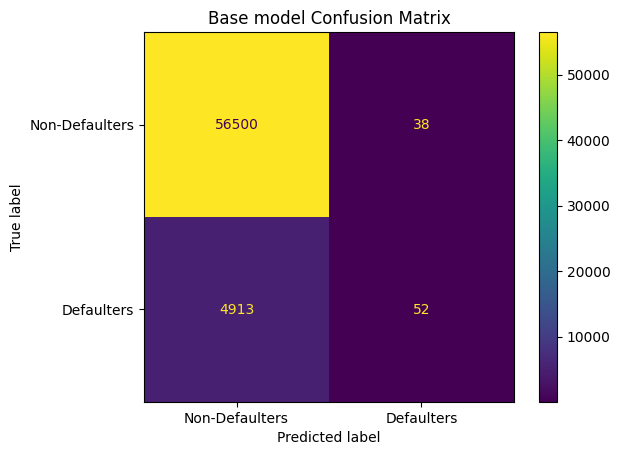

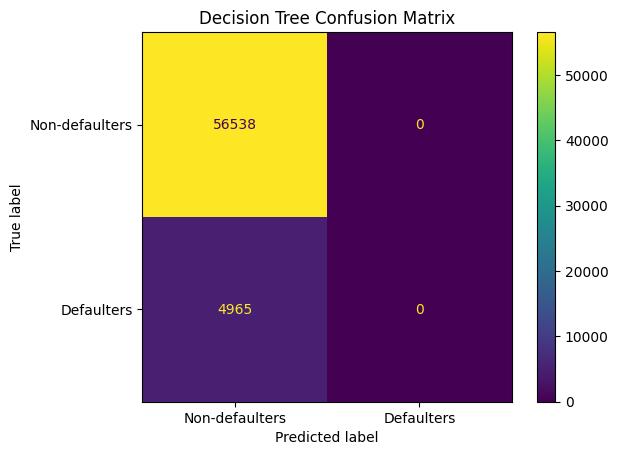

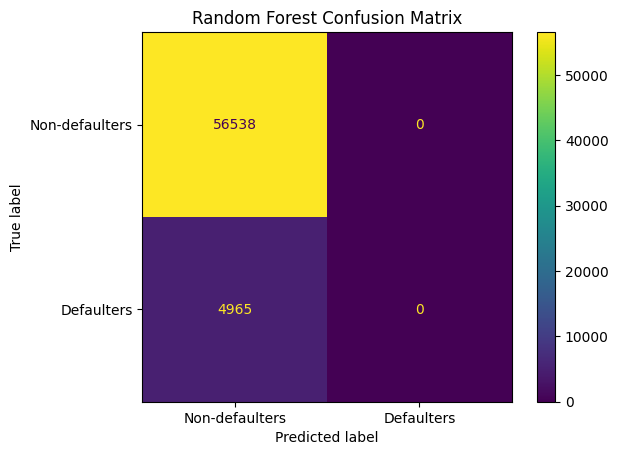

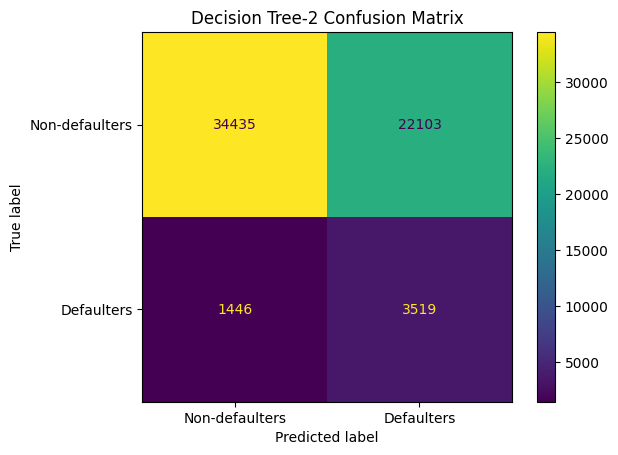

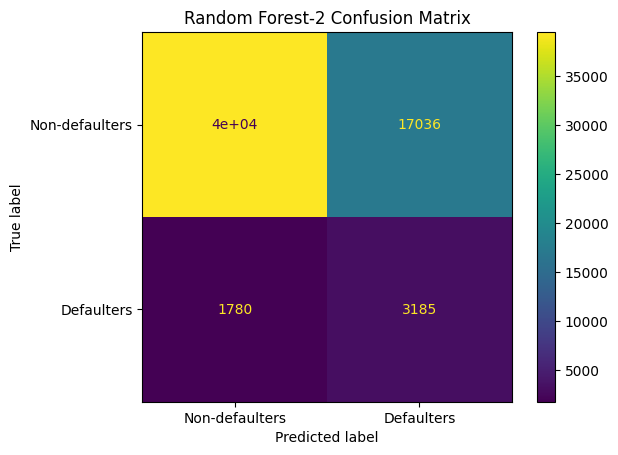

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Base model
base_cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    base_cm,
    display_labels=['Non-Defaulters', 'Defaulters']
)
disp.plot()
disp.ax_.set_title("Base model Confusion Matrix")

# Decision Tree
dt_cm = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(
    dt_cm,
    display_labels=['Non-defaulters','Defaulters']
)
disp.plot()
disp.ax_.set_title("Decision Tree Confusion Matrix")

# Random Forest
rf_cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(
    rf_cm,
    display_labels=['Non-defaulters','Defaulters']
)
disp.plot()
disp.ax_.set_title("Random Forest Confusion Matrix")

# Decision Tree 2
dt_cm_2 = confusion_matrix(y_test, y_pred_dt_2)
disp = ConfusionMatrixDisplay(
    dt_cm_2,
    display_labels=['Non-defaulters','Defaulters']
)
disp.plot()
disp.ax_.set_title("Decision Tree-2 Confusion Matrix")

# Random Forest 2
rf_cm_2 = confusion_matrix(y_test, y_pred_rf_2)
disp = ConfusionMatrixDisplay(
    rf_cm_2,
    display_labels=['Non-defaulters','Defaulters']
)
disp.plot()
disp.ax_.set_title("Random Forest-2 Confusion Matrix")

plt.show()


### DAY 4
* Setup cross validation (k-fold) instead of single test split and if the metric is stable across folds = model is reliable.
* Tune the parameters of the random forest model to control the *Tree complexity, leaf purity and Ensemble strength*. 
* Run grid search to obtain the best values for the parameters.
* Perform evaluation on the tuned model and compare with the previous ones.

In [22]:
# Setup of the k-fold cross-validation
cv = StratifiedKFold(
    n_splits=5,
    shuffle= True,
    random_state=42
)

rf_cv_scores_base = cross_val_score(
    rf_model_2, 
    X_train,
    y_train, 
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

rf_cv_scores_base, rf_cv_scores_base.mean(), rf_cv_scores_base.std()

(array([0.72527721, 0.72899127, 0.72982154, 0.72683988, 0.72347298]),
 np.float64(0.7268805757511123),
 np.float64(0.0023361704562258525))

In [22]:
# Tuning of the parameters of the random_forest model to identify the best values for the params through grid_search

param_grid = {
    'classifier__max_depth':[6,8,10],
    'classifier__min_samples_leaf': [20,50,100],
    'classifier__n_estimators': [100,200]
}

grid = GridSearchCV(
    estimator = rf_model_2,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

grid.best_params_, grid.best_score_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


({'classifier__max_depth': 10,
  'classifier__min_samples_leaf': 100,
  'classifier__n_estimators': 200},
 np.float64(0.7315731074540782))

In [23]:
best_rf = grid.best_estimator_

y_proba_best_rf = best_rf.predict_proba(X_test)[:,1]
y_pred_best_rf = best_rf.predict(X_test)

roc_auc_best_rf = roc_auc_score(y_test, y_proba_best_rf)
recall_best_rf = recall_score(y_test, y_pred_best_rf)
precision_best_rf = precision_score(y_test, y_pred_best_rf)
f1_best_rf = f1_score(y_test, y_pred_best_rf)

evaluation_df.loc[len(evaluation_df)] = {"model_name": "Best_Random_Forest", "roc_auc": roc_auc_best_rf, "recall": recall_best_rf, "precision": precision_best_rf, "f1_score": f1_best_rf}

evaluation_df

,model_name,roc_auc,recall,precision,f1_score
0,LogisticRegression,0.749874,0.010473,0.577778,0.020574
1,DecisionTreeClassifier,0.709521,0.000000,0.000000,0.000000
2,RandomForestClassifier,0.734195,0.000000,0.000000,0.000000
3,DecisionTreeClassifier_2,0.712210,0.708761,0.137343,0.230098
4,RandomForestClassifier_2,0.731069,0.641490,0.157510,0.252918
5,Best_Random_Forest,0.734838,0.631823,0.162002,0.257882


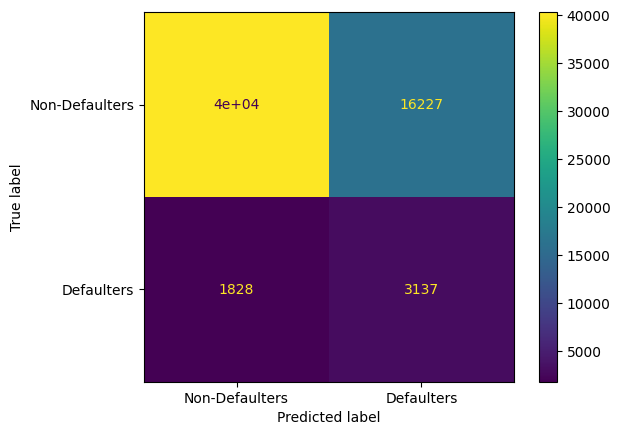

In [25]:
best_rf_cm = confusion_matrix(y_test, y_pred_best_rf)
disp = ConfusionMatrixDisplay(
    best_rf_cm,
    display_labels=['Non-Defaulters', 'Defaulters']
)
disp.plot()
plt.show()

In [ ]:
# Tuning of the parameters of the random_forest model to identify the best values for the params through grid_search
# Tuning them through recall this time to see how differently it might look
param_grid = {
    'classifier__max_depth':[6,8,10],
    'classifier__min_samples_leaf': [20,50,100],
    'classifier__n_estimators': [100,200]
}

grid_2 = GridSearchCV(
    estimator = rf_model_2,
    param_grid=param_grid,
    cv=cv,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

In [25]:
grid_2.best_params_, grid_2.best_score_

({'classifier__max_depth': 6,
  'classifier__min_samples_leaf': 50,
  'classifier__n_estimators': 200},
 np.float64(0.6609768378650555))

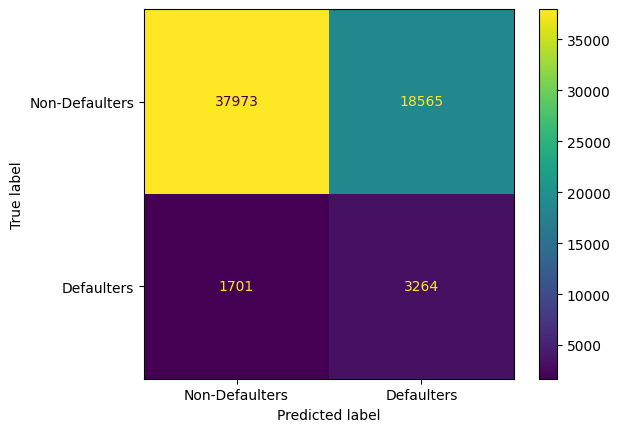

In [27]:
recall_rf = grid_2.best_estimator_
y_pred_recall_rf = recall_rf.predict(X_test)

recall_rf_cm = confusion_matrix(y_test, y_pred_recall_rf)
disp = ConfusionMatrixDisplay(
    recall_rf_cm,
    display_labels=['Non-Defaulters', 'Defaulters']
)
disp.plot()

Fitting 5 folds for each of 9 candidates, totalling 45 fits


(np.float64(0.7107387181176945),
 {'classifier__max_depth': 8, 'classifier__min_samples_leaf': 100})

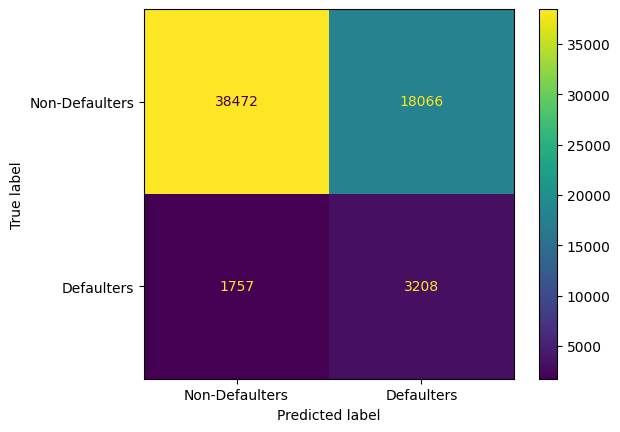

In [11]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle= True,
    random_state=42
)

dt_param_grid = {'classifier__max_depth':[6,8,10], 'classifier__min_samples_leaf': [20,50,100]}

grid_dt = GridSearchCV(
    estimator=dt_model_2,
    param_grid=dt_param_grid,
    cv= cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_
best_dt_cm = confusion_matrix(y_test, best_dt.predict(X_test))
cm_disp = ConfusionMatrixDisplay(best_dt_cm, display_labels=['Non-Defaulters','Defaulters'])
cm_disp.plot()

grid_dt.best_score_, grid_dt.best_params_


In [ ]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle= True,
    random_state=42
)

dt_param_grid = {'classifier__max_depth':[6,8,10], 'classifier__min_samples_leaf': [20,50,100]}

grid_dt_2 = GridSearchCV(
    estimator=dt_model_2,
    param_grid=dt_param_grid,
    cv= cv,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)
grid_dt_2.fit(X_train, y_train)

best_dt = grid_dt_2.best_estimator_
best_dt_cm = confusion_matrix(y_test, best_dt.predict(X_test))
cm_disp = ConfusionMatrixDisplay(best_dt_cm, display_labels=['Non-Defaulters','Defaulters'])
cm_disp.plot()

grid_dt_2.best_score_, grid_dt_2.best_params_
